## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

## Project description
The supermarket chain Good Seed would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage. 
We are asked to build and evaluate a model for verifying people's age, keeping the following in mind:
- Shops are equipped with cameras in checkout area which are triggered when a person is buying alcohol.
- Computer vision methods can be used to determine age of a person from a photo.
- We have a set of photographs of people with their ages indicated.

## Data

The dataset is stored in the `/datasets/faces/` folder, there we can find:
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

datagen = ImageDataGenerator(validation_split = 0.25, rescale = 1./255, horizontal_flip = True, vertical_flip = True, rotation_range = 90)

train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

labels.head()

Found 7591 validated image filenames.


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


2 columns (numerical target- regression task).

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.duplicated().sum()

0

- Dataset includes 7591 entries.
- No duplicates.
- No missing values.
- Correct data types.

In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Avg. `real_age` is 31.2, min is 1 and max is 100.

## EDA

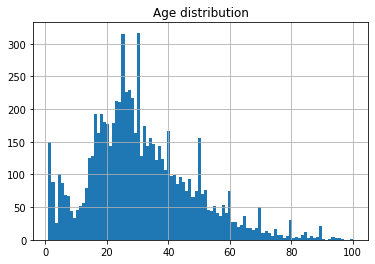

In [6]:
labels['real_age'].hist(bins=100)
plt.title('Age distribution');

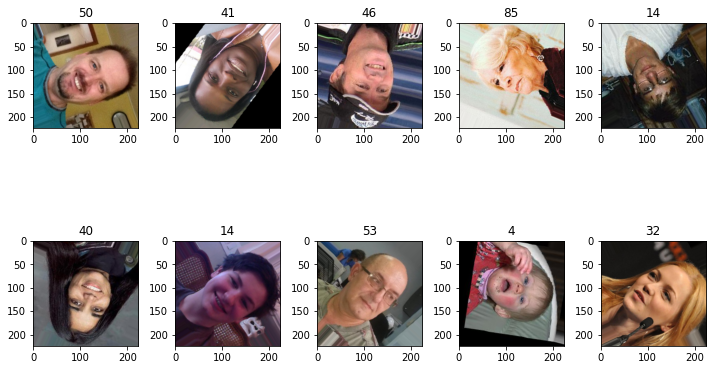

In [7]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(target[i])
    plt.imshow(features[i])
    plt.tight_layout()

### Findings

- `real_age` is slightly positively skewed, close to normal distribution. 

- Neural network model may overestimate/underestimate age.

- Loss function will be 'MSE'.

- Final layer will have 1 neuron to return single value output and will be added to ResNet50 backbone as Dense layer.

- Negative values shouldn't be computed, thus 'ReLu' activation will be used to transform them to zeros.

## Modeling

Defining necessary functions to train our model on the GPU platform and building a single script containing all of them along with the initialization section.

In [9]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

In [10]:
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

In [11]:
def create_model(input_shape):
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [12]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

## Preparing script to run on GPU platform

In [13]:
init_str ='''
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model'''

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

## Conclusions

In summary, in this project we developed a neural network model to predict a person's age from a photograph. 
Project metric is MAE and should be no more than 8.

<ins>We followed the methodology as follows:<ins>
- Open data file and study general information.
- Exploratory data analysis.
- Load train and test sets.
- Model by MAE.
- And now, final conclusion.
 
<ins>Findings:<ins>
- Dataset includes 7591 entries.

- `real_age` is slightly positively skewed, close to normal distribution.
    
- Model is ResNet50 backbone with 'relu' activation to transform negative values into 0 and final layer with 1 neuron to return single output obtained by regression.

- Loss function is 'mse' and metric is 'mae'.

- batch_size=32 and learning_rate=0.001.
 
- Model resulted in MAE: 6.8481 after 20 epochs, meaning that on average, model's predicted age diverges from real age by slightly less than 7 years.

- Minimum legal age for purchasing alcohol is between 18 and 21 years old. 
Model may identify an 11.1 year old (18-6.84) as an 18 year old, thus causing a problem. Project description mentions lowest recorded MAE of 5.4 years yet even that isn't enough in this case (12.6 year old may be identified as an 18 year old).

<ins>Recommendations:<ins>
Determine age range instead of specific age. For example:
- Find age of person from regions of the world where newborns' birthdates aren't/weren't registered. 
- Find age of unidentified deceased person to assist forensic anthropologists.
- Find age of person for any place with age based entry ticket pricing (i.e. zoo, cinema, public transportation, park, museum).